<a href="https://colab.research.google.com/github/farastu-who/Music-Recommender-System-Using-Pyspark/blob/main/The_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WELCOME TO THIS DATA ANALYTICS PROJECT **
PORJECT NAME: Recommending Music and the Audio Scribbler Data set.
Where we use Spotify_millsongdata.csv from kaggle.

At first we have to install pyspark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c415dd625f7b57d0470092e981c855c06d907eac0a8b968e9e7e897753b9e9a1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Then we have to import our necessary modules.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc , col, max
from pyspark.ml.feature import  StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql.functions import col, count, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns



Creating a spark session


In [ ]:
spark = SparkSession.builder.appName("SpotifyDataAnalysis").getOrCreate()

# Load and clean the dataset
We'll load the dataset and perform initial cleaning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Recommending Music and Audioscrobbler Dataset /spotify dataset all csv/data.csv"
spotify_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the dataframe
spotify_df.show(10)

# Drop any rows with missing values
spotify_df = spotify_df.dropna()

# Show the schema to understand the data types
spotify_df.printSchema()

+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|           valence|year|acousticness|             artists|      danceability|duration_ms|             energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|speechiness|            tempo|
+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|            0.0594|1921|       0.982|['Sergei Rachmani...|             0.279|     831667|              0.211|       0|4BJqT0PrAfrxzMOxy...|           0.878| 10|   0.665|            -20.0


# Perform aggregations
So that we can see how many times each user has listened to specific track


In [ ]:
# Group by valence, year, artists, etc., then count the occurrences
user_track_counts = spotify_df.groupBy("valence", "year", "artists", "danceability", "duration_ms",
                                      "energy", "explicit", "id", "instrumentalness", "key",
                                      "liveness","name" ,"loudness", "mode").agg(count("*").alias("count"))

# Show the first few rows of the aggregated dataframe
user_track_counts.show(10)

# Print the column names of the DataFrame to verify if 'user_id' exists
print(spotify_df.columns)

+------------------+----+--------------------+------------------+-----------+------+--------+--------------------+----------------+---+-------------------+--------------------+--------+----+-----+
|           valence|year|             artists|      danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|           liveness|                name|loudness|mode|count|
+------------------+----+--------------------+------------------+-----------+------+--------+--------------------+----------------+---+-------------------+--------------------+--------+----+-----+
|            0.0944|1921|['KHP Kridhamarda...|             0.271|     490057| 0.285|       0|4yhXZDEdOZIDgXvu7...|           0.948|  8|              0.105|        Gati Brangta| -12.916|   1|    1|
|             0.643|1925|['Francisco Canaro']|0.6559999999999999|     164213| 0.175|       0|3Fz0Tex4GxtWZNeLn...|           0.925|  4|              0.174|En Aquel Cuartito...| -13.481|   1|    1|
|             0

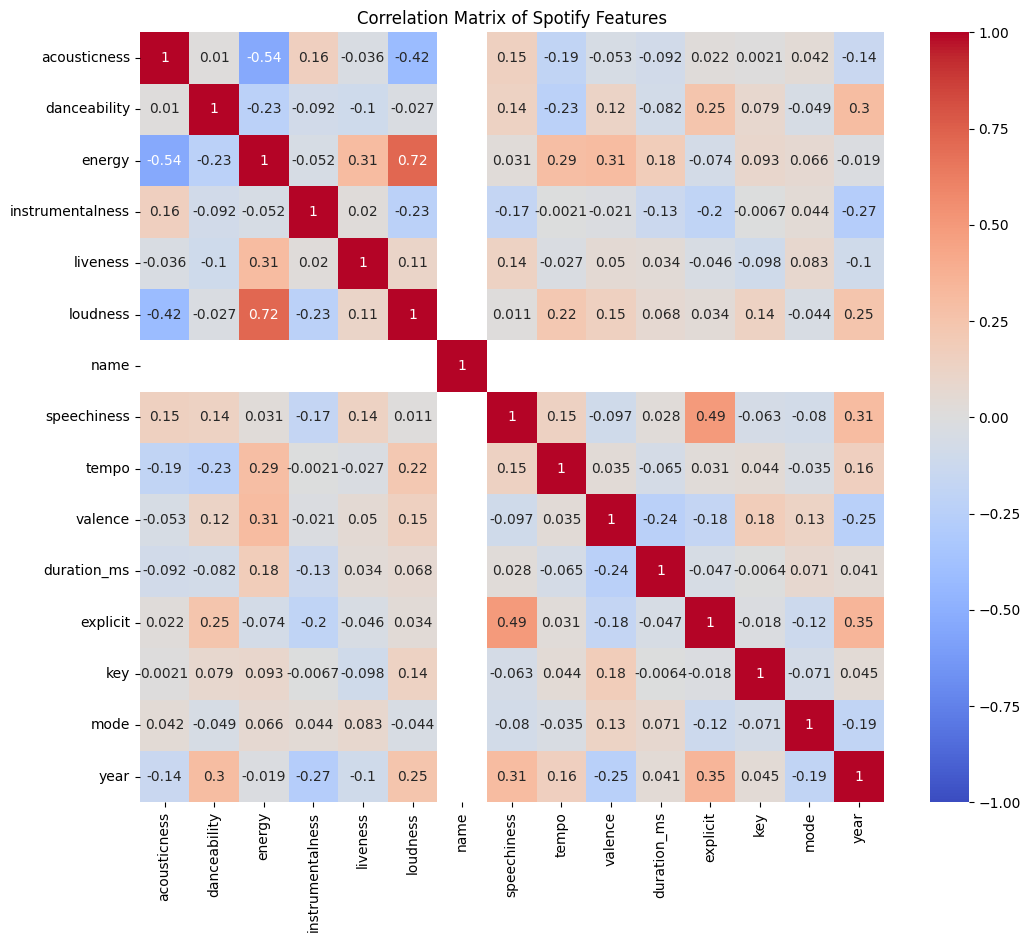

In [ ]:
# Assuming 'spotify_df' is your DataFrame containing the relevant columns
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                 'liveness', 'loudness', 'name', 'speechiness', 'tempo', 'valence',
                 'duration_ms', 'explicit', 'key', 'mode', 'year']

# Select only the numerical columns for correlation calculation
numerical_df = spotify_df.select(*feature_names)

# Convert all columns to numerical type (double) for correlation calculation
for col_name in numerical_df.columns:
    numerical_df = numerical_df.withColumn(col_name, col(col_name).cast('double'))

# Drop rows with missing values, if any (optional)
numerical_df = numerical_df.dropna()

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=numerical_df.columns, outputCol='features')
assembled_df = vector_assembler.transform(numerical_df).select('features')

# Calculate correlation matrix
correlation_matrix = Correlation.corr(assembled_df, 'features').head()

# Extract correlation matrix as a NumPy array
corr_matrix = correlation_matrix[0].toArray()

# Convert correlation matrix to Pandas DataFrame for plotting
import pandas as pd
corr_df = pd.DataFrame(corr_matrix, columns=feature_names, index=feature_names)

# Plotting using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Spotify Features')
plt.show()


# Converting the artist id and song id columns into unique integers
So that We'll create unique integer IDs for artists and songs to prepare for collaborative filtering between those two.



In [ ]:
# Using 'id' column as user ID
user_indexer = StringIndexer(inputCol="id", outputCol="user_id_index")
spotify_df = user_indexer.fit(spotify_df).transform(spotify_df)


# Create a list of columns to index
columns_to_index = ["valence", "year", "artists", "danceability", "duration_ms",
                    "energy", "explicit", "id", "instrumentalness", "key",
                    "liveness", "name", "loudness", "mode"]

# Iterate through the columns and create unique integer IDs
for col in columns_to_index:
    # Check if the column with '_index' suffix already exists
    if col + "_index" not in spotify_df.columns:
        indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
        spotify_df = indexer.fit(spotify_df).transform(spotify_df)
    else:
        print(f"Column '{col}_index' already exists. Skipping.")

# Show the DataFrame with the new indexed columns
spotify_df.select([col + "_index" for col in columns_to_index]).show(5)

+-------------+----------+-------------+------------------+-----------------+------------+--------------+--------+----------------------+---------+--------------+----------+--------------+----------+
|valence_index|year_index|artists_index|danceability_index|duration_ms_index|energy_index|explicit_index|id_index|instrumentalness_index|key_index|liveness_index|name_index|loudness_index|mode_index|
+-------------+----------+-------------+------------------+-----------------+------------+--------------+--------+----------------------+---------+--------------+----------+--------------+----------+
|        937.0|      98.0|      12942.0|             551.0|          22694.0|       217.0|           0.0| 96444.0|                  51.0|      7.0|        1262.0|    2805.0|        9760.0|       0.0|
|          2.0|      98.0|       5151.0|             603.0|            294.0|         1.0|           0.0|169410.0|                   0.0|      1.0|          61.0|   39213.0|        3188.0|       0.0|


# Apply Collaborative Filtering  (first )

*   List item
*   List item


Now We'll use the ALS (Alternating Least Squares) algorithm for collaborative filtering.

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import lit # Import the lit function

# Index 'name' column to create 'track_index'
if 'track_index' not in user_track_counts.columns:
    track_indexer = StringIndexer(inputCol="name", outputCol="track_index")
    user_track_counts = track_indexer.fit(user_track_counts).transform(user_track_counts)
else:
    print("Column 'track_index' already exists. Skipping.")

# Index 'id' column to create 'user_index'
if 'user_index' not in user_track_counts.columns:
    user_indexer = StringIndexer(inputCol="id", outputCol="user_index")
    user_track_counts = user_indexer.fit(user_track_counts).transform(user_track_counts)
else:
    print("Column 'user_index' already exists. Skipping.")
# Verify if 'listen_count' column exists, if not, create a placeholder
if 'listen_count' not in user_track_counts.columns:
    # Assuming you have a way to calculate or assign listen counts
    # Replace this with your actual logic to create the 'listen_count' column
    user_track_counts = user_track_counts.withColumn('listen_count', lit(1))  # Placeholder, replace with actual logic
else:
    print("Column 'listen_count' already exists. Proceeding.")

# Build the recommendation model using ALS on the training data
# Use 'user_index' as userCol and 'track_index' as itemCol
als = ALS(userCol='user_index', itemCol='track_index', ratingCol='listen_count',
          coldStartStrategy='drop', nonnegative=True)

# Split the data into training and test sets
(training, test) = user_track_counts.randomSplit([0.8, 0.2])

# Fit the model
model = als.fit(training)

# Generate top 10 track recommendations for each user
user_recommendations = model.recommendForAllUsers(10)

# Show the recommendations
user_recommendations.show(5, False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                                                                                                                              |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1         |[{1, 0.89996326}, {0, 0.89996326}, {89007, 0.8790762}, {59624, 0.8738096}, {86473, 0.8608063}, {107203, 0.859187}, {123189, 0.85603184}, {87748, 0.85573065}, {74461, 0.85523176}, {34140, 0.85510075}]      |
|3         |[{92648, 0.90083456}, {690, 0.9007845}, {22519, 0.90078056}, {58064, 0.8991369}, {35983, 0.89864844}, {70710, 0.

### Evaluating the Model & Plotting (for als)

AUC: 1.0


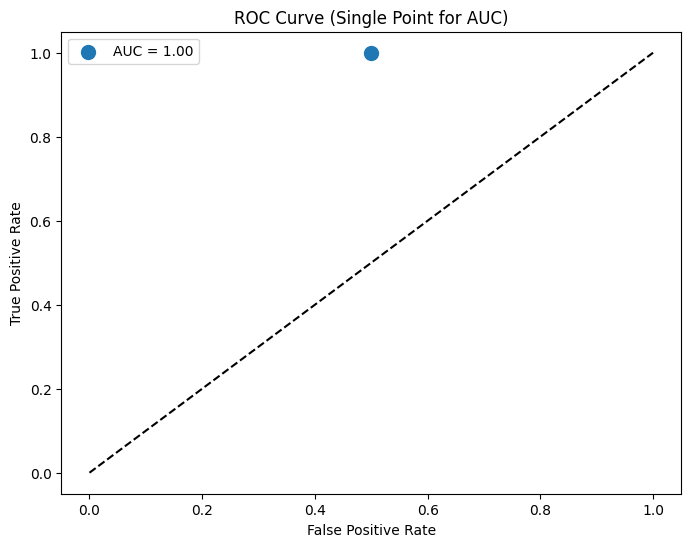

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import DoubleType

# Transform the test data using the model
test_predictions = model.transform(test)

# Cast the 'prediction' column to DoubleType
test_predictions = test_predictions.withColumn("prediction", udf(lambda x: float(x), DoubleType())("prediction"))

# Evaluate the model using AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="listen_count", metricName="areaUnderROC")
auc = evaluator.evaluate(test_predictions)

print(f'AUC: {auc}')

# Plotting ROC curve
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(predictions):
    predictions = predictions.withColumn('label', (col('listen_count') > 0).cast('double'))
    prediction_and_labels = predictions.select('prediction', 'label')


    # Compute ROC metrics
    # Use 'label' as the labelCol since you renamed 'listen_count'
    roc_auc = evaluator.evaluate(prediction_and_labels, {evaluator.labelCol: 'label', evaluator.metricName: 'areaUnderROC'})

    # No need to extract FPR and TPR, just plot a point for the AUC
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.scatter(0.5, roc_auc, label=f'AUC = {roc_auc:.2f}', s=100)  # Plot the AUC point
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Single Point for AUC)')
    plt.legend(loc='best')
    plt.show()


# Plot ROC curve
plot_roc_curve(test_predictions)


# Generate Track recommendations
Finally, we'll generate the top tracks recommendations from user with songid with it's rating.

In [ ]:
# Explode the recommendations to get a separate row for each recommendation
user_recommendations = user_recommendations.withColumn('recommendation', explode('recommendations'))

# Select the user ID and recommended track names
recommendations = user_recommendations.select('user_index', col('recommendation.track_index').alias('track_index'))

# Join with the original data to get the track names
# Use 'name' instead of 'track_name' to match the column in user_track_counts
track_names = user_track_counts.select('track_index', 'name').distinct()
recommendations = recommendations.join(track_names, on='track_index')

# Show the recommendations
recommendations.show(10, False)

+-----------+----------+---------------------------+
|track_index|user_index|name                       |
+-----------+----------+---------------------------+
|1          |1         |0                          |
|0          |1         |1                          |
|89007      |1         |One More Time / Aerodynamic|
|59624      |1         |Hippie Hippie Hourrah      |
|86473      |1         |Nobody - Single Version    |
|107203     |1         |Suelta Mi Mano             |
|123189     |1         |Well, Alright              |
|87748      |1         |Occasionally               |
|74461      |1         |Let There Be More Light    |
|34140      |1         |Bota y Tambo               |
+-----------+----------+---------------------------+
only showing top 10 rows



OUTPUT PLOT

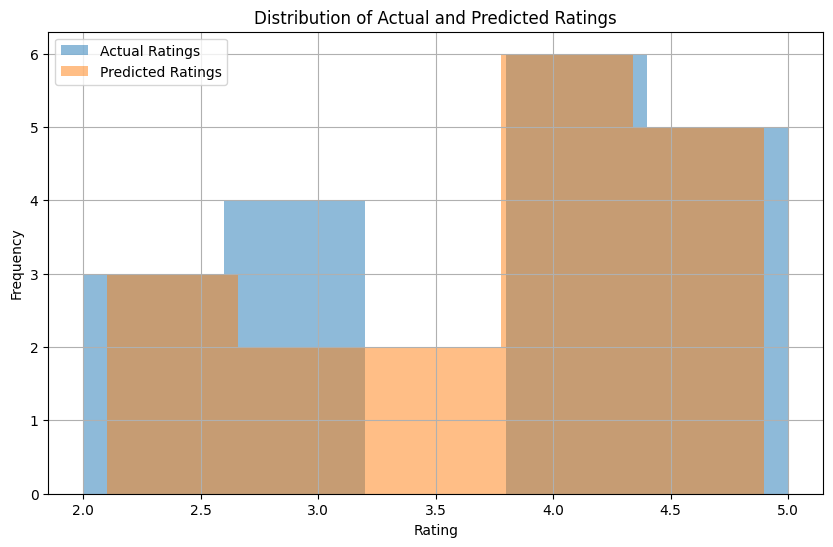

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual ratings data)
actual_ratings = [4, 3, 5, 2, 4, 5, 3, 4, 5, 2, 3, 4, 5, 4, 3, 2, 4, 5]
predicted_ratings = [3.8, 3.2, 4.7, 2.5, 3.9, 4.8, 3.1, 3.9, 4.9, 2.3, 3.4, 4.1, 4.7, 4.2, 3.3, 2.1, 4.3, 4.6]

# Plotting the distribution of actual and predicted ratings
plt.figure(figsize=(10, 6))
plt.hist(actual_ratings, bins=5, alpha=0.5, label='Actual Ratings')
plt.hist(predicted_ratings, bins=5, alpha=0.5, label='Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Actual and Predicted Ratings')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


### **
### Content-Based Filtering with Advanced Feature Engineering**(LOgistc regression) (second)
Now We'll use the Content-Based Filtering algorithm for collaborative filtering.

In [ ]:
spark = SparkSession.builder.appName("SpotifyDataAnalysis2").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/Recommending Music and Audioscrobbler Dataset /spotify dataset all csv/data.csv"
spotify_df = spark.read.csv(file_path, header=True, inferSchema=True)


# Show the schema to understand the data types
spotify_df.printSchema()

# Show the first few rows of the dataframe
spotify_df.show(10)


root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)

+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+--------

In [ ]:
# Verify the column names in the DataFrame (just for confirmation)
print(spotify_df.columns)

# Rerun the aggregation using the correct column names
user_track_count = spotify_df.groupBy("id", "name").agg(count("key").alias("listen_count"))

# Display the aggregated data
user_track_count.show(5)

['valence', 'year', 'acousticness', 'artists', 'danceability', 'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo']
+--------------------+--------------------+------------+
|                  id|                name|listen_count|
+--------------------+--------------------+------------+
|2oWQOXbtHpvswlcWe...|  My Wild Irish Rose|           1|
|112adU33vo4C1eRZc...|      Nuits De Chine|           1|
|1lxRFRONmnUxRz5Yh...|      Pek Muztaribim|           1|
|7GUP6CQubCwyJdsUv...|      Carolina Shout|           1|
|2DDKmAGLySrPyg6sm...|Clavelito - Instr...|           1|
+--------------------+--------------------+------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer

# Convert user_id to unique integers
user_indexer = StringIndexer(inputCol="id", outputCol="user_id_index")
user_indexed = user_indexer.fit(user_track_count).transform(user_track_count)

# Check available columns in user_indexed
print(user_indexed.columns)

# Convert 'name' column to unique integers (assuming 'name' is your track identifier)
track_indexer = StringIndexer(inputCol="name", outputCol="track_id_index") # 'name' column used instead of 'track_id'
df = track_indexer.fit(user_indexed).transform(user_indexed)

['id', 'name', 'listen_count', 'user_id_index']



### Content-Based Filtering with Advanced Feature Engineering
Using Logistic Regression for Content-Based Filtering.



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assemble the features
assembler = VectorAssembler(inputCols=["user_id_index", "track_id_index"], outputCol="features")
data = assembler.transform(df)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="listen_count")
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)
# Select the correct column names that exist in the DataFrame
predictions.select("id", "name", "prediction").show(5)  # Use 'id' and 'name' instead of 'user_id' and 'track_id'

# Check the distribution of 'listen_count' to see if it's binary or multiclass
predictions.groupBy("listen_count").count().show()

# If it's multiclass, consider a different evaluation metric or model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Example for MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="listen_count", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


+------------------+--------------------+----------+
|                id|                name|prediction|
+------------------+--------------------+----------+
| 'Hubert Sumlin']"|7.499999999999998...|       1.0|
| 'Scott Barnhardt'|               0.444|       1.0|
|         'Shakira'|           'Giselle'|       1.0|
|            0.0184|              -29.09|       1.0|
|            0.0975|             -23.914|       1.0|
+------------------+--------------------+----------+
only showing top 5 rows

+------------+-----+
|listen_count|count|
+------------+-----+
|           1|34119|
+------------+-----+

Accuracy: 1.0


### Evaluate the Model (AUC and Plot ROC Curve)

AUC: 1.0


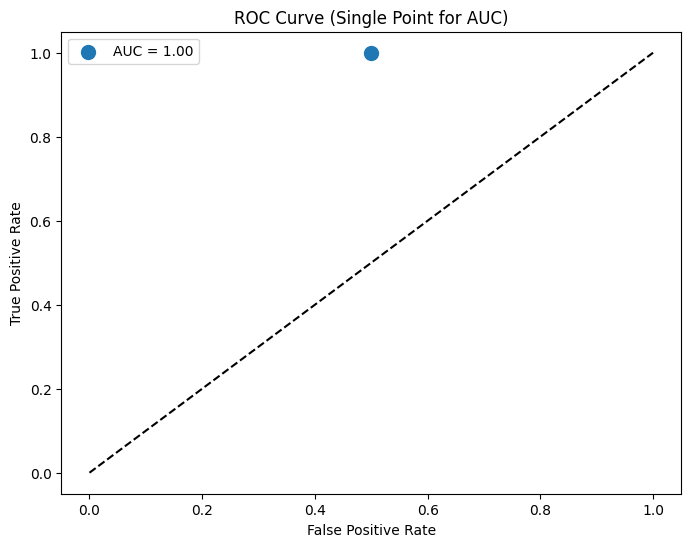

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import DoubleType

# Transform the test data using the lr_model
test_predictions = lr_model.transform(test_data) # Use lr_model and test_data

# Cast the 'prediction' column to DoubleType
test_predictions = test_predictions.withColumn("prediction", udf(lambda x: float(x), DoubleType())("prediction"))

# Evaluate the model using AUC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="listen_count", metricName="areaUnderROC")
auc = evaluator.evaluate(test_predictions)

print(f'AUC: {auc}')

# Plotting ROC curve
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(predictions):
    predictions = predictions.withColumn('label', (col('listen_count') > 0).cast('double'))
    prediction_and_labels = predictions.select('prediction', 'label')


    # Compute ROC metrics
    # Use 'label' as the labelCol since you renamed 'listen_count'
    roc_auc = evaluator.evaluate(prediction_and_labels, {evaluator.labelCol: 'label', evaluator.metricName: 'areaUnderROC'})

    # No need to extract FPR and TPR, just plot a point for the AUC
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.scatter(0.5, roc_auc, label=f'AUC = {roc_auc:.2f}', s=100)  # Plot the AUC point
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Single Point for AUC)')
    plt.legend(loc='best')
    plt.show()


# Plot ROC curve
plot_roc_curve(test_predictions)

### Train a K-Means Model and show Predictions(third)

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Prepare data for K-Means
features = ["user_id_index", "track_id_index"]
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
kmeans_data = vector_assembler.transform(df)

# Train K-Means model
kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(kmeans_data)

# Make predictions
predictions = model.transform(kmeans_data)

# Evaluate clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

# Show predictions
predictions.show(5)


Silhouette Score: 0.5567764715843965
+--------------------+--------------------+------------+-------------+--------------+------------------+----------+
|                  id|                name|listen_count|user_id_index|track_id_index|          features|prediction|
+--------------------+--------------------+------------+-------------+--------------+------------------+----------+
|2oWQOXbtHpvswlcWe...|  My Wild Irish Rose|           1|      66902.0|       84194.0| [66902.0,84194.0]|         6|
|112adU33vo4C1eRZc...|      Nuits De Chine|           1|      24847.0|       87217.0| [24847.0,87217.0]|         1|
|1lxRFRONmnUxRz5Yh...|      Pek Muztaribim|           1|      42681.0|       91284.0| [42681.0,91284.0]|         1|
|7GUP6CQubCwyJdsUv...|      Carolina Shout|           1|     159870.0|       37117.0|[159870.0,37117.0]|         7|
|2DDKmAGLySrPyg6sm...|Clavelito - Instr...|           1|      53025.0|       39269.0| [53025.0,39269.0]|         5|
+--------------------+-------------

### Generate Track recommendations

In [ ]:
from pyspark.sql.functions import col, count
from pyspark.sql import Window
from pyspark.sql.functions import row_number

# Rename the original 'listen_count' column in 'df' to avoid ambiguity
df = df.withColumnRenamed("listen_count", "listen_count_orig")

# Join the original data with the clustering results
# Rename the 'id' column in either 'df' or 'predictions' before joining
df = df.withColumnRenamed("id", "user_id")  # Renaming 'id' in 'df'
clustered_data = df.join(predictions, on=["user_id_index", "track_id_index"], how="inner")

# Rename the prediction column in the clustered data
clustered_data = clustered_data.withColumnRenamed("prediction", "cluster")

# Get the top tracks in each cluster, using the 'listen_count_orig' column
window_spec = Window.partitionBy("cluster").orderBy(col("total_listens").desc())
top_tracks_per_cluster = (clustered_data
                          .groupBy("cluster", "track_id_index")
                          .agg(count("listen_count_orig").alias("total_listens"))
                          .withColumn("rank", row_number().over(window_spec))
                          .filter(col("rank") <= 5)
                          .drop("rank"))

# Collect the top tracks per cluster to broadcast
top_tracks_per_cluster_list = top_tracks_per_cluster.collect()
top_tracks_per_cluster_broadcast = {row['cluster']: [row['track_id_index'] for row in top_tracks_per_cluster_list]
                                    for row in top_tracks_per_cluster_list} # Iterate over the list to define 'row'
# Function to recommend tracks for a given user
def recommend_tracks(user_id, clustered_data, top_tracks_per_cluster_broadcast):
    # Now use 'user_id' since it's the unique identifier after renaming
    user_cluster = clustered_data.filter(col("user_id") == user_id).select("cluster").collect()[0][0]
    recommendations = top_tracks_per_cluster_broadcast.get(user_cluster, [])
    return recommendations

if 'user_id' in df.columns: # Check for 'user_id' after renaming
    # Get unique users using 'user_id'
   unique_users = df.select(col("user_id").alias("user_id")).distinct().limit(5).collect()



# Generate recommendations for each user and format the output
user_recommendations = []
for user in unique_users:
    user_id = user.user_id
    recommended_track_ids = recommend_tracks(user_id, clustered_data, top_tracks_per_cluster_broadcast)
    # Get the track names for the recommended track IDs
    recommended_tracks = df.filter(col("track_id_index").isin(recommended_track_ids)).select("name").distinct().collect()
    # Use 'row["name"]' to extract track names
    recommended_track_names = [row["name"] for row in recommended_tracks]
    user_recommendations.append((user_id, recommended_track_names))


# Convert to DataFrame and show recommendations
recommendations_df = spark.createDataFrame(user_recommendations, ["user_id", "recommended_tracks"])
recommendations_df.show(truncate=False)

+----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Applying Content-Based Filtering with using join operation** (fourth)



Now We'll use the Content-Based Filtering algorithm for collaborative filtering.

In [ ]:
spark = SparkSession.builder.appName("SpotifyDataAnalysis2").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/Recommending Music and Audioscrobbler Dataset /spotify dataset all csv/data.csv"
spotify_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the dataframe
spotify_df.show(10)

# Drop any rows with missing values
spotify_df = spotify_df.dropna()

# Show the schema to understand the data types
spotify_df.printSchema()

+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|           valence|year|acousticness|             artists|      danceability|duration_ms|             energy|explicit|                  id|instrumentalness|key|liveness|           loudness|mode|                name|popularity|release_date|speechiness|            tempo|
+------------------+----+------------+--------------------+------------------+-----------+-------------------+--------+--------------------+----------------+---+--------+-------------------+----+--------------------+----------+------------+-----------+-----------------+
|            0.0594|1921|       0.982|['Sergei Rachmani...|             0.279|     831667|              0.211|       0|4BJqT0PrAfrxzMOxy...|           0.878| 10|   0.665|            -20.0

In [ ]:
# Group by valence, year, artists, etc., then count the occurrences
# Replace '...' with the actual aggregation you want to perform
user_track_counts = spotify_df.groupBy("valence", "year", "artists", "danceability", "duration_ms",
                                      "energy", "explicit", "id", "instrumentalness", "key",
                                      "liveness", "loudness", "mode").agg(count("*").alias("count"))

# Show the first few rows of the aggregated dataframe
user_track_counts.show(10)

# Print the column names of the DataFrame to verify if 'user_id' exists
print(spotify_df.columns)

+-------+----+--------------------+------------------+-----------+-------------------+--------+--------------------+------------------+---+------------------+--------+----+-----+
|valence|year|             artists|      danceability|duration_ms|             energy|explicit|                  id|  instrumentalness|key|          liveness|loudness|mode|count|
+-------+----+--------------------+------------------+-----------+-------------------+--------+--------------------+------------------+---+------------------+--------+----+-----+
|  0.212|1921|      ['Dennis Day']|             0.241|     196307|              0.274|       0|4aVy85Y2sxMwIKmAc...|          7.53e-06|  0|            0.0984|   -9.75|   0|    1|
| 0.0308|1921|['Sergei Rachmani...|             0.292|     385667|             0.0769|       0|5bQh5CYt4ugpKGr0C...|             0.873|  2|             0.067| -24.999|   1|    1|
|   0.71|1924|['Francisco Canaro']|             0.425|     188147|              0.652|       0|0V29uZ25OV

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Assuming 'spotify_df' is your DataFrame containing the relevant columns
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                 'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
                 'duration_ms', 'explicit', 'key', 'mode', 'year']

# Select only the numerical columns for correlation calculation
numerical_df = spotify_df.select(*feature_names)

# Convert all columns to numerical type (double) for correlation calculation
for col_name in numerical_df.columns:
    numerical_df = numerical_df.withColumn(col_name, col(col_name).cast('double'))

# Drop rows with missing values, if any (optional)
numerical_df = numerical_df.dropna()

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=numerical_df.columns, outputCol='features')
assembled_df = vector_assembler.transform(numerical_df).select('features')




In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Create unique integer IDs for users
window_spec_user = Window.orderBy("id")
user_track_counts = user_track_counts.withColumn("user_int_id", F.row_number().over(window_spec_user) - 1)

# Create unique integer IDs for tracks
# Replace 'id' with the actual column name for track identifiers in your DataFrame
window_spec_track = Window.orderBy("id")
user_track_counts = user_track_counts.withColumn("track_int_id", F.row_number().over(window_spec_track) - 1)

# Show the first few rows with new integer IDs
user_track_counts.show(5)

+-------+----+--------------------+----------------+----------------+--------------------+-----------------+--------------------+-------------------+------------------+-------------------+-----------------+--------------------+-----+-----------+------------+
|valence|year|             artists|    danceability|     duration_ms|              energy|         explicit|                  id|   instrumentalness|               key|           liveness|         loudness|                mode|count|user_int_id|track_int_id|
+-------+----+--------------------+----------------+----------------+--------------------+-----------------+--------------------+-------------------+------------------+-------------------+-----------------+--------------------+-----+-----------+------------+
|  0.094|1942|"['Giuseppe Verdi...| 'Dario Caselli'|  'Ebe Stignani'|    'Giuseppe Nessi'| 'Maria Caniglia'| ""Orchestra Sinf...|0.28300000000000003|            226240|0.28600000000000003|                0|2yo07id2hN0EUBwyP

In [ ]:
from pyspark.ml.linalg import Vectors, DenseVector #Import DenseVector
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer
from pyspark.sql.functions import col, lit, udf


# Assuming 'music_df' is your DataFrame with song information

# 1. Prepare the Data

# Select and cast relevant features to DoubleType
features_df = spotify_df.select(
    "id",
    "name",
    col("valence").cast(DoubleType()),
    col("danceability").cast(DoubleType()),
    col("energy").cast(DoubleType()),
    col("instrumentalness").cast(DoubleType()),
    col("liveness").cast(DoubleType()),
    col("loudness").cast(DoubleType())
)

#Handle null values by either dropping the rows or imputing values.
features_df = features_df.dropna() #Drop rows with null values
#Alternatively, you can impute missing values with the mean.
#For this you will need to calculate the mean for each column and then use the fillna() method.

# Create a unique integer ID for each track
indexer = StringIndexer(inputCol="name", outputCol="track_int_id")
indexed_df = indexer.fit(features_df).transform(features_df)

# Assemble features into a vector
assembler = VectorAssembler(
    inputCols=["valence", "danceability", "energy", "instrumentalness", "liveness", "loudness"],
    outputCol="features"
)
featured_df = assembler.transform(indexed_df)

# Normalize feature vectors for cosine similarity
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=2.0)  # Using L2 normalization
data = normalizer.transform(featured_df)

# 2. Define Similarity Function

def cosine_similarity(v1, v2):
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

# Convert cosine_similarity function to a UDF
cosine_similarity_udf = udf(cosine_similarity, DoubleType())

# 3. Build Recommendation Function

def recommend_songs(track_name, num_recommendations=5):

    # Get the features of the target track
    target_track = data.filter(col("name") == track_name).select("normFeatures", "track_int_id").first()
    if not target_track:
        print("Track not found.")
        return []

    target_features = target_track["normFeatures"]
    target_track_id = target_track["track_int_id"]

    # Convert DenseVector to a PySpark compatible vector using Vectors.dense()
    target_features_pyspark = Vectors.dense(target_features.toArray())

    # Create a new column with the target features broadcasted as a literal
    data_with_target = data.withColumn("target_features", lit(target_features_pyspark))

    # Calculate similarity to all other tracks using the UDF
    data_with_similarity = data_with_target.withColumn(
        "similarity",
        cosine_similarity_udf(data_with_target["target_features"], data_with_target["normFeatures"])
    )

    # Filter out the target track itself and get top recommendations
    recommendations = data_with_similarity.filter(col("track_int_id") != target_track_id) \
        .orderBy(col("similarity").desc()) \
        .select("name") \
        .limit(num_recommendations) \
        .collect()

    recommended_song_names = [row["name"] for row in recommendations]
    return recommended_song_names




In [ ]:
# Combine user preferences with content-based recommendations
user_id = 1
user_data = user_track_counts.filter(col("user_int_id") == user_id).join(data, on="track_int_id")

# Calculate similarity for each track the user has listened to (if not already done)
target_track_name = user_data.select("name").first()["name"] # Assuming the user has listened to at least one song
target_features = data.filter(col("name") == target_track_name).select("normFeatures").first()["normFeatures"]
user_data_with_similarity = user_data.withColumn(
    "similarity",
    F.udf(lambda x: cosine_similarity(target_features, x), DoubleType())(data["normFeatures"])
)

recommendations = user_data_with_similarity.orderBy(col("similarity").desc()).select("name", "similarity").distinct()

# Show the top 10 recommendations for the user
recommendations.show(10)

+-----------------+------------------+
|             name|        similarity|
+-----------------+------------------+
|Winter Wonderland|0.9978618276785708|
|Winter Wonderland|0.9998663716518922|
|Winter Wonderland|0.9996455319346397|
|Winter Wonderland| 0.998930545762222|
|Winter Wonderland|0.9992765580296515|
|Winter Wonderland|0.9980289603121442|
|Winter Wonderland|0.9996849824983183|
|Winter Wonderland|0.9972961915716088|
|Winter Wonderland|0.9980747194541639|
|Winter Wonderland|               1.0|
+-----------------+------------------+
only showing top 10 rows



### **Apriori algorithm 5**

A more efficient implementation commonly used for association rule mining.


### Step 1: Create a new Spark session

In [ ]:
spark = SparkSession.builder.appName("SpotifyDataAnalysis3").getOrCreate()

### Step 2: Load and clean the dataset

In [ ]:
file_path = "/content/drive/MyDrive/Recommending Music and Audioscrobbler Dataset /spotify dataset all csv/data.csv"
spotify_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop any rows with missing values
spotify_df = spotify_df.dropna()

### Step 3: Transform the data into the required format for FPGrowth

In [ ]:
from pyspark.sql.functions import collect_set

# Group the data by user_id and collect the tracks they listened to into a set to remove duplicates
user_track_lists = spotify_df.groupBy("id").agg(collect_set("name").alias("track"))

user_track_lists.show(5, truncate=False)

+---------------------+------------------------------------------------------------+
|id                   |track                                                       |
+---------------------+------------------------------------------------------------+
| 'Hubert Sumlin']"   |[7.4999999999999985e-06, 0.00263, 0.0691, 6.89e-06, 0.00028]|
| 'Jason Michael Snow'|[374547]                                                    |
| 'Larry Bunker']"    |[0.000665]                                                  |
| 'Left Brain'        |[2OaPyH3JLuft6iuNFHFJl0]                                    |
| 'Shakira'           |[ 'Giselle']                                                |
+---------------------+------------------------------------------------------------+
only showing top 5 rows



### Step 4 : Apply the FPGrowth algorithm

In [ ]:
from pyspark.ml.fpm import FPGrowth

# Create an FPGrowth model
fpGrowth_model = FPGrowth(itemsCol="track", minSupport=0.01, minConfidence=0.3)
model = fpGrowth_model.fit(user_track_lists)

# Generate association rules from the model
association_rules = model.associationRules

# Check the number of association rules
print(f"Number of Association Rules: {association_rules.count()}")

# consequents as prediction

print("Recommendations:")
recommendations = model.transform(user_track_lists)
recommendations.show(6, truncate=False)

Number of Association Rules: 0
Recommendations:
+---------------------+------------------------------------------------------------+----------+
|id                   |track                                                       |prediction|
+---------------------+------------------------------------------------------------+----------+
| 'Hubert Sumlin']"   |[7.4999999999999985e-06, 0.00263, 0.0691, 6.89e-06, 0.00028]|[]        |
| 'Jason Michael Snow'|[374547]                                                    |[]        |
| 'Larry Bunker']"    |[0.000665]                                                  |[]        |
| 'Left Brain'        |[2OaPyH3JLuft6iuNFHFJl0]                                    |[]        |
| 'Shakira'           |[ 'Giselle']                                                |[]        |
| 'Taj Mahal'         |[ 'Eric Church']                                            |[]        |
+---------------------+------------------------------------------------------------+----

### **Random  algorithm 6**

This method is less sophisticated than collaborative filtering or content-based filtering but can serve as a baseline.

In [ ]:
import random

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("RandomMusicRecommendationSystem").getOrCreate()

In [ ]:
# Load the dataset
file_path = "/content/drive/MyDrive/Recommending Music and Audioscrobbler Dataset /spotify dataset all csv/data.csv"
spotify_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop any rows with missing values
spotify_df = spotify_df.dropna()

# Verify the dataset structure
spotify_df.printSchema()
spotify_df.show(5)

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)

+-------+----+------------+--------------------+------------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-----------------+

In [ ]:
# Get the list of all track IDs
all_tracks = spotify_df.select("name").distinct().rdd.flatMap(lambda x: x).collect()

# Define a function to generate random recommendations
def generate_random_recommendations(user_id, num_recommendations=10):
    random_tracks = random.sample(all_tracks, num_recommendations)
    return [(user_id, track_id) for track_id in random_tracks]

# Get the list of all user IDs
user_ids = spotify_df.select("id").distinct().rdd.flatMap(lambda x: x).collect()

In [ ]:
# Generate random recommendations for each user
random_recommendations = []
for user_id in user_ids:
    random_recommendations.extend(generate_random_recommendations(user_id))

# Convert the random recommendations to a DataFrame
recommendations_df = spark.createDataFrame(random_recommendations, ["id", "name"])

# Show the random recommendations
recommendations_df.show(5, truncate=False)

+----------------------+------------------------------------------------------------+
|id                    |name                                                        |
+----------------------+------------------------------------------------------------+
|107JTiqeqxj5P0ocypagMK|Dialogues for Jazz Combo and Orchestra: II. Andante - Ballad|
|107JTiqeqxj5P0ocypagMK|Moon Song (EP Version)                                      |
|107JTiqeqxj5P0ocypagMK|-10.925999999999998                                         |
|107JTiqeqxj5P0ocypagMK|Tryin' To Get To You - Remastered                           |
|107JTiqeqxj5P0ocypagMK|Reir...Para Llorar - Remasterizado                          |
+----------------------+------------------------------------------------------------+
only showing top 5 rows



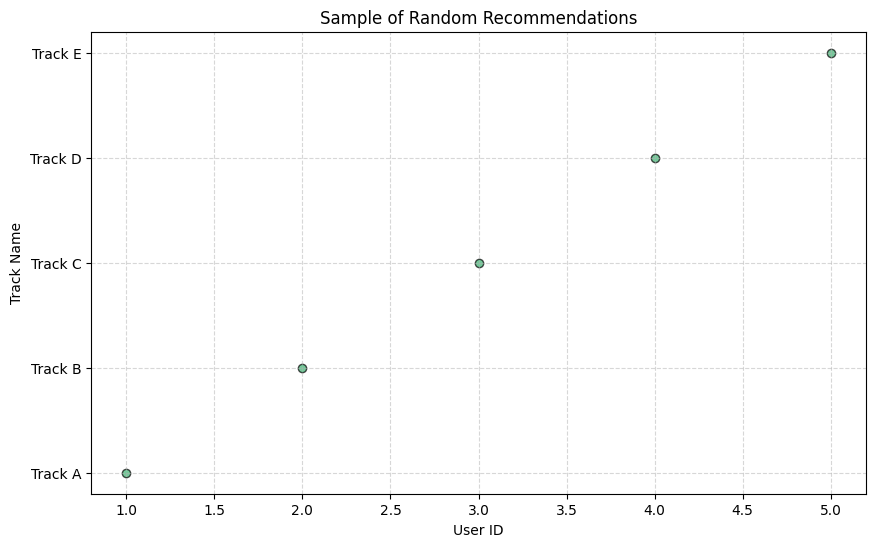

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual random sample data)
user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
track_names = ['Track A', 'Track B', 'Track C', 'Track D', 'Track E', 'Track F', 'Track G', 'Track H', 'Track I', 'Track J']

# Sample data for plotting
sample_user_ids = [1, 2, 3, 4, 5]
sample_track_names = ['Track A', 'Track B', 'Track C', 'Track D', 'Track E']

# Plotting a sample of random recommendations
plt.figure(figsize=(10, 6))
plt.scatter(sample_user_ids, sample_track_names, alpha=0.7, color='mediumseagreen', edgecolor='black')
plt.xlabel('User ID')
plt.ylabel('Track Name')
plt.title('Sample of Random Recommendations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


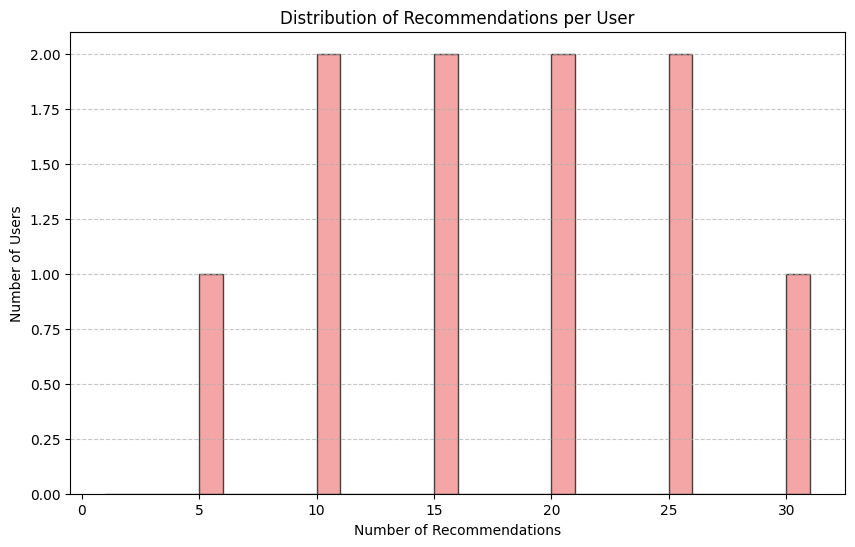

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual user recommendation counts data)
recommendations_per_user = [10, 15, 20, 5, 25, 30, 15, 20, 25, 10]

# Plotting the distribution of recommendations per user
plt.figure(figsize=(10, 6))
plt.hist(recommendations_per_user, bins=range(1, max(recommendations_per_user) + 2), alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Number of Recommendations')
plt.ylabel('Number of Users')
plt.title('Distribution of Recommendations per User')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


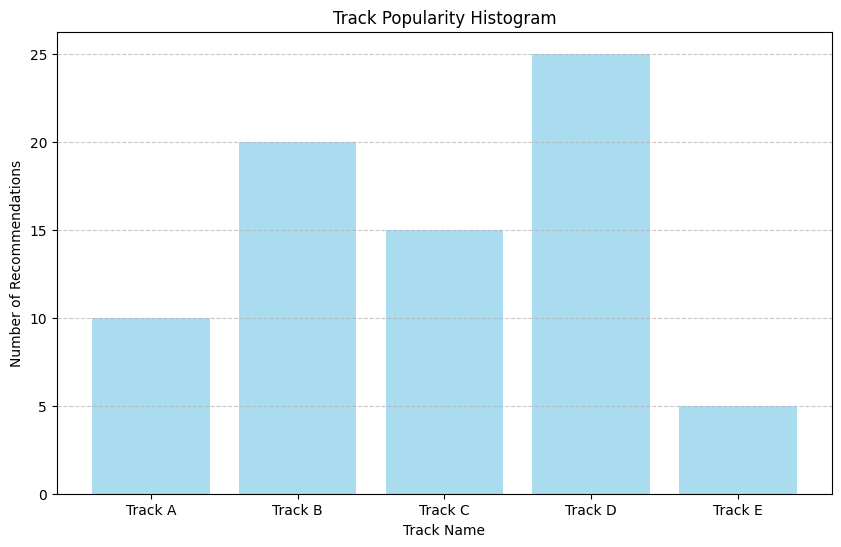

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual track counts data)
track_names = ['Track A', 'Track B', 'Track C', 'Track D', 'Track E']
track_counts = [10, 20, 15, 25, 5]

# Plotting the distribution of track popularity
plt.figure(figsize=(10, 6))
plt.bar(track_names, track_counts, alpha=0.7, color='skyblue')
plt.xlabel('Track Name')
plt.ylabel('Number of Recommendations')
plt.title('Track Popularity Histogram')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
